## Condy Kan
# Assignment 6: Advanced Data Management & Regressions
### Concept
The Canadian border sees significant traffic flow from the US. The Government of Canada collects detailed information about wait times at its various crossings and publishes the data at https://open.canada.ca/data/en/dataset/000fe5aa-1d77-42d1-bfe7-458c51dacfef.

These files provide periodic information for all crossings. A traveler can peruse these files and determine typical wait times and use it for travel planning. However, the files are exceedingly large – one would need software such as Python to efficiently utilize the data. This file contains the crossing information for 2010-2014

### Requirements
Analyze information on the Lewiston Bridge crossing only, and produce a report that reflects these specs:
   1. Use regression analysis to model wait time (Y variable) as a function of time of day, weekday/weekend, other holidays, and month.
   2. Run two variants of the model:
       - OLS, using wait time as a continuous variable
       - Logistic, using waiting time as categorical variable by using a reasonsable threshold and slotting values into high or low. 
   3. Present results and provide a discussion comparing the two models.
   4. Discuss (without implementing) additional features that can improve the model. This discussion should demonstrate your data sense.
   5. Produce a report using expectation established in prior projects and in class discussions. 

You would also need to use judgment to construct the Y variable for the logistic model. In some sense, this project is designed to teach you that even simple data science projects require thought and judgment and that there is no such thing as an easy project when using real data.

In [602]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression
import holidays
myfile1 = "C:/Users/Condy/Downloads/bwt-taf-2010-2014-eng.csv"
df = pd.read_csv(myfile1)

We want to analyze the data on the Lewiston Bridge crossing only and focus on the wait time for the travellers. We  would extract the data and drop the Commerical Flow column. 

In [603]:
myfile1 = "C:/Users/Condy/Downloads/bwt-taf-2010-2014-eng.csv"
df = pd.read_csv(myfile1)
dfLewiston = df[df["CBSA Office"].str.contains("Lewiston Bridge")].copy()
dfLewiston = dfLewiston.drop(columns=["Commercial Flow"])
dfLewiston.head(5)

,CBSA Office,Location,Updated,Travellers Flow
369413,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 13:06 EDT,No Delay
369414,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 12:05 EDT,No Delay
369415,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:09 EDT,No Delay
369416,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:07 EDT,No Delay
369417,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:07 EDT,No Delay


To see if there are a pattern of closing the Lewiston Bridge

In [604]:
dfClosed = dfLewiston[dfLewiston["Travellers Flow"].str.contains("Closed")].copy()
dfClosed["Updated"].value_counts()

2011-04-29 08:34 EDT    2
2011-04-29 08:35 EDT    2
2011-04-28 13:28 EDT    1
2011-04-28 11:42 EDT    1
2011-04-28 13:07 EDT    1
2011-04-28 14:02 EDT    1
2011-04-28 12:09 EDT    1
2011-04-28 13:08 EDT    1
2011-04-28 12:10 EDT    1
2011-04-28 15:01 EDT    1
Name: Updated, dtype: int64

It seems that there is no pattern of closing the bridge so we could drop it. We wanted this variable as a continuous variable, "No Delay" would be labeled as '0'. 

In [609]:
import warnings
warnings.filterwarnings('ignore')
dfLewiston = dfLewiston.replace(to_replace =["No Delay"], value ="0")
dfLewiston = dfLewiston[dfLewiston["Travellers Flow"] != 'Closed']
dfLewiston["Updated"] = pd.to_datetime(dfLewiston["Updated"], )
for col in list(dfLewiston):
    print(col)
    print(np.sort(dfLewiston[col].unique()))

CBSA Office
['Queenston-Lewiston Bridge']
Location
['Queenston, ON']
Updated
['2010-03-31T23:05:00.000000000' '2010-04-01T02:08:00.000000000'
 '2010-04-01T04:13:00.000000000' ... '2014-04-04T11:09:00.000000000'
 '2014-04-04T12:05:00.000000000' '2014-04-04T13:06:00.000000000']
Travellers Flow
['0' '10' '105' '120' '135' '150' '20' '30' '420' '45' '60' '75' '90']


Since there is only one unique value in CBSA Office and Location columns, we would like to drop them. For the updated colum, it would be separated by year, month, day, hour, minutes, month, and day. Then the Weekdays would be labeled as 0 and Weekend would be labeled as 1 in the Weekday_Weekend column.

In [597]:
0dfLewiston["Travellers Flow"] = pd.to_numeric(dfLewiston["Travellers Flow"])
dfLewiston['Year']=dfLewiston['Updated'].dt.year 
dfLewiston['Month']=dfLewiston['Updated'].dt.month 
dfLewiston['Day']=dfLewiston['Updated'].dt.day
dfLewiston['Time']=dfLewiston['Updated'].dt.time
dfLewiston['Hour'] = dfLewiston['Updated'].dt.hour 
dfLewiston['Minute'] = dfLewiston['Updated'].dt.minute 
dfLewiston['MonthName']=dfLewiston['Updated'].dt.month_name()
dfLewiston['DayName']=dfLewiston['Updated'].dt.day_name()
dfLewiston = dfLewiston.drop(columns=['CBSA Office', 'Location', "Updated"])
days = {'Monday': 0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':1, 'Sunday':1} 
dfLewiston["Weekday_Weekend"] = dfLewiston["DayName"].map(days)
dfLewiston = dfLewiston.rename(columns={"Travellers Flow": "Wait_Time"})
dfLewiston.head(3)

,Wait_Time,Date,Year,Month,Day,Time,Hour,Minute,MonthName,DayName,Weekday_Weekend
369413,0,2014-04-04,2014,4,4,13:06:00,13,6,April,Friday,0
369414,0,2014-04-04,2014,4,4,12:05:00,12,5,April,Friday,0
369415,0,2014-04-04,2014,4,4,11:09:00,11,9,April,Friday,0


Since the Lewiston Bridge is in Canada, we would like to include public holidays in Canada. The holidays in Canada would be used as a categorical variable in the dataframe because holidays may affect the wait time. Non-holiday dates would be labeled as 0 and holiday dates would be labeled as 1. 

In [600]:
CAHolidays = {}
for day in holidays.CA(years = [2010,2011,2012,2013,2014]):
    key = day.strftime(format="%Y-%m-%d")
    CAHolidays[key] = 1
dfLewiston["Holidays"] = dfLewiston["Date"].map(CAHolidays)
dfLewiston['Holidays'] = dfLewiston['Holidays'].replace(np.nan, 0).astype(int)

We would like to use the correlation matrix to understand the variables and ensure that the independent variables are uncorrelated with each other. Also, we learned that Month, Hour, Weekday_Weekend, and Holidays columns have the some correlations with Wait_Time. Those variables matter and help to determine wait time. We would like to do OLS with those variables. 

In [599]:
dfLewiston.corr()

,Wait_Time,Year,Month,Day,Hour,Minute,Weekday_Weekend,Holidays
Wait_Time,1.000000,0.004437,0.071120,0.020449,0.274833,-0.060424,0.148152,0.104143
Year,0.004437,1.000000,-0.266617,-0.010420,0.019881,0.226969,0.007082,-0.020632
Month,0.071120,-0.266617,1.000000,0.020537,0.001380,0.000390,0.000915,0.035142
Day,0.020449,-0.010420,0.020537,1.000000,0.000875,0.004667,-0.015933,-0.041771
Hour,0.274833,0.019881,0.001380,0.000875,1.000000,-0.212662,0.002056,0.003018
Minute,-0.060424,0.226969,0.000390,0.004667,-0.212662,1.000000,0.012798,0.005322
Weekday_Weekend,0.148152,0.007082,0.000915,-0.015933,0.002056,0.012798,1.000000,-0.075501
Holidays,0.104143,-0.020632,0.035142,-0.041771,0.003018,0.005322,-0.075501,1.000000


Such as, hour matters for the travellers because each hour has an effect on wait time.

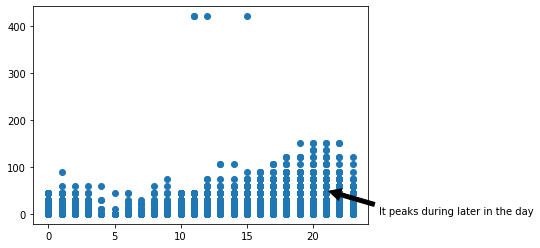

In [566]:
fig, ax = plt.subplots()
ax.scatter('Hour', 'Wait_Time', data=dfLewiston)
# annotate
ax.annotate('It peaks during later in the day', xy=(21, 50), xytext=(25, .3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

We would like to use Months because there are more delays during summer months such as June, July, and August. There are spikes in Months so it would be good to have that in the OLS regressions. 

In [591]:
pd.crosstab(dfLewiston.Month, dfLewiston.Wait_Time)

Wait_Time,0,10,20,30,45,60,75,90,105,120,135,150,420
Month,,,,,,,,,,,,,
1,3715,60,43,42,30,1,1,0,0,0,0,0,0
2,3227,84,47,37,44,20,11,2,3,0,0,0,0
3,3431,183,137,107,58,5,1,0,0,0,0,0,0
4,2973,139,149,115,91,22,18,11,0,0,0,0,2
5,2802,187,173,185,140,44,31,15,4,6,4,3,0
6,2634,282,230,192,110,17,11,1,0,0,0,0,2
7,2392,356,321,287,210,43,20,9,1,4,0,4,0
8,2134,342,361,480,359,55,35,9,7,0,0,0,0
9,2783,254,184,174,144,35,22,2,3,3,0,0,0


In addition, holidays may affect the wait time so it should be included in the model.  

In [589]:
pd.crosstab(dfLewiston.Holidays, dfLewiston.Wait_Time)

Wait_Time,0,10,20,30,45,60,75,90,105,120,135,150,420
Holidays,,,,,,,,,,,,,
0,34743,2407,1974,1905,1351,253,142,35,10,10,1,4,4
1,932,86,69,81,104,41,29,18,10,6,4,3,0


For OLS regressions, we created the second orders of month and hour to model curvature.

In [561]:
dfLewiston['Month2'] =dfLewiston["Month"]**2
dfLewiston['Hour2'] =dfLewiston["Hour"]**2
fl = "Wait_Time ~ Hour + Month + Month2 + Hour2 + Weekday_Weekend + Holidays"
result = sm.ols(formula=fl, data=dfLewiston).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Wait_Time   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     1291.
Date:                Sat, 25 Apr 2020   Prob (F-statistic):               0.00
Time:                        00:50:08   Log-Likelihood:            -1.7525e+05
No. Observations:               44222   AIC:                         3.505e+05
Df Residuals:                   44215   BIC:                         3.506e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -12.6341      0.271    -46.649      0.000     -13.165     -12.103
Hour                0.7727      0.034     23.020      0.000       0.707       0.838
Month               3.3395      0.076     43.857      0.000       3.190       3.489
Month2             -0.2366      0.006    -41.490      0.000      -0.248      -0.225
Hour2              -0.0097      0.001     -6.973      0.000      -0.012      -0.007
Weekday_Weekend     4.8425      0.134     36.238      0.000       4.581       5.104
Holidays            9.9706      0.350     28.495      0.000       9.285      10.656
==============================================================================
Omnibus:                    51002.022   Durbin-Watson:                   0.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22916950.944
Skew:                           5.503   Prob(JB):                         0.00
Kurtosis:                     113.979   Cond. No.                     1.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OLS tried to find the parameters and the error would be minimized. There is a discontinuity in the data that may make it a bad fitting. So the second order of month and hours were made to minimize the sum of squared residuals. The p-values for all independent variables are less than 0.05, which shows that they are significant.  Since the Lewiston Bridge data has the majority of "no delay", they make delays the outilers. There are many days with no delay, the model gave the the best result, which is the horizontal line close to 0.  In other words, if we leave the values of 0 (no delay) then we will have a lot of points at 0 that bias the model towards 0. We would like to drop the values with 0 to make the model unbiased then perform OLS to predict the wait time (delays). 

In [562]:
dfLewiston1 = dfLewiston[dfLewiston['Wait_Time'] !=0]
f2 = "Wait_Time ~ Hour + Month + Month2 + Weekday_Weekend + Holidays"
result2 = sm.ols(formula=f2, data=dfLewiston1).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Wait_Time   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     166.5
Date:                Sat, 25 Apr 2020   Prob (F-statistic):          1.91e-169
Time:                        00:50:08   Log-Likelihood:                -37152.
No. Observations:                8547   AIC:                         7.432e+04
Df Residuals:                    8541   BIC:                         7.436e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.7349      1.439      1.206      0.228      -1.086       4.556
Hour                0.7186      0.046     15.466      0.000       0.628       0.810
Month               3.4646      0.334     10.386      0.000       2.811       4.119
Month2             -0.2536      0.023    -10.900      0.000      -0.299      -0.208
Weekday_Weekend     7.0114      0.421     16.667      0.000       6.187       7.836
Holidays           17.5330      0.931     18.832      0.000      15.708      19.358
==============================================================================
Omnibus:                     9820.907   Durbin-Watson:                   0.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3488663.392
Skew:                           5.506   Prob(JB):                         0.00
Kurtosis:                     101.361   Cond. No.                         532.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since we dropped the values with 0, the parameters used for the regression still have a hard transition due to the discontinuity between months and hours. The R-Squared and Adj. R-Squared values are around 8%. They are lower than the previous OLS model, with no delays. There is a majority of no delays in the data and OLS gave the linear relationship close to 0 in the previous model. The coefficient is when an unit change in the predictor variable that would result in a change in the wait time. If we cross the bridge later in the day, weekend, month or on holidays, it would increase by an unit. The wait_time would be increased by 0.7186, 3.4646, 7.0114, and 17.5330 respectively. Furthermore, each p-value of the independent variable are less than 0.05 which means they are statistically significant in the model. In addition, the second order of hour was dropped because the p-value was above 0.05 and may be non-significant.


For the Logistic Regression, we would like to make the wait time variable as a categorical variable. This is because we have 80% chances of no delay, we would like to split in chances of no delay or  delay. This would be done by coding it with two different values as "low" and "high". However, the logistic regressions would not able to work with string values in the dependent variable (Y variable). So we would label low as 0 and high as 1. In terms of low, the values would be no delay only. On the other hands, a delay would be considered as high and labeled as 1. 

In [563]:
y = [0,1,800]
labels=["Low", "High"]
dfLewiston2 = dfLewiston.copy()
dfLewiston2['WaitTime'] = pd.cut(dfLewiston2['Wait_Time'], bins=y, labels=labels, include_lowest=True)
WaitTime = {"Low": 0, "High": 1}
dfLewiston2["y"] = dfLewiston2["WaitTime"].map(WaitTime)
dfLewiston2["y"] = pd.to_numeric(dfLewiston2['y'])
dfLewiston2 = dfLewiston2.drop(columns=["Wait_Time", "Month2", "Hour2"])


count_no_delay = len(dfLewiston2[dfLewiston2['y'] == 0])
count_delay = len(dfLewiston2[dfLewiston2['y']==1])
pct_of_no_delay = count_no_delay/(count_no_delay+count_delay)
print("percentage of no delay (Low) is", pct_of_no_delay*100)
pct_of_delay = count_delay/(count_no_delay+count_delay)
print("percentage of delay (High) is", pct_of_delay*100)

percentage of no delay (Low) is 80.67251594229117
percentage of delay (High) is 19.327484057708833


In [564]:
fl3 = "y ~ Month + Hour + Weekday_Weekend + Holidays" 
logit_model=sm.logit(formula=fl3, data=dfLewiston2).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.419162
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                44222
Model:                          Logit   Df Residuals:                    44217
Method:                           MLE   Df Model:                            4
Date:                Sat, 25 Apr 2020   Pseudo R-squ.:                  0.1462
Time:                        00:50:08   Log-Likelihood:                -18536.
converged:                       True   LL-Null:                       -21710.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.2188      0.049    -86.866      0.000      -4.314      -4.124
Month         

In this logistic regression, the factor level 0 and 1 of y variable (Wait time) represents as no delay and delay respectively. Each indepedent variable (Month, Hour, Weekday_Weekend, and Holidays) are meaningful and periodic. The coefficient (coef) are the values for the logistic regression equation that are in log-odds units. So the equation is log(p/1-p) = -4.2188 + 0.0799*Month + 0.1392*Hour + 0.8624*Weekday_Weekend + 0.9715*Holidays. So the variables provide the value in the fit since the p-values for all the variables are smaller than 0.05 that indicates they are significant.

We used wait time variable as a continuous variable and caterogical variable for OLS and Logistic Regression. In the OLS and logistic models, I modeled the wait time to predict wait time as a function in hour, weekday/weekend, holidays, and month. In OLS models, the r-squared values are low that implies that it is not a good fit but additional features may improve the models. There are several factors that affect wait time. For example, events, such as festivals and concerts, may help with the models. Secondly, weather may play a big part in wait time. Harsh weather conditions may affect travellers flow so it would be good to have that in the data. Moreover, it may cause traffic collision. Other factors causes car accidents as well such as mechanical failing. Those features would help to predict wait time better. 

Overall, I gained hand-on experience with analyzing time data and using them as independent varibales to make regression models. I had the opportunity to use my judgement and data science skills in this project. I performed two different kind of regressions to understand that we could not solely depend on OLS or can use variables as categorical variables. I learned the importance of data management and regressions. With all the past assignments, I became more comfortable working with data, tackling the problems, and finding insights. 